# Conditional GAN with MNIST

* `Conditional Generative Adversarial Nets`[arXiv:1411.1784](https://arxiv.org/abs/1411.1784)
  * Mehdi Mirza, Simon Osindero
  
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and [`eager execution`](https://www.tensorflow.org/guide/eager).
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
* based on DCGAN model

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

import image_utils as utils

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'cgan'
train_dir = 'train/' + model_name + '/exp1/'
max_epochs = 30
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 5e-4
k = 1 # the number of step of learning D before learning G
num_classes = 10 # number of classes for MNIST
num_examples_to_generate = num_classes
noise_dim = 100
MNIST_SIZE = utils.MNIST_SIZE

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), _ = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data.reshape(-1, 28, 28, 1).astype('float32')
train_data = train_data / 255.
train_labels = train_labels.astype(np.int32)

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
def convert_shape_and_type_for_labels(x, y):
  y = tf.one_hot(y, depth=num_classes)
  y = tf.reshape(y, shape=[1, 1, num_classes])
  y = tf.cast(y, dtype = tf.float32)
  return x, y

In [5]:
tf.set_random_seed(219)

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:N], train_labels[:N]))
train_dataset = train_dataset.shuffle(buffer_size = N)
train_dataset = train_dataset.map(convert_shape_and_type_for_labels)
train_dataset = train_dataset.batch(batch_size = batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: ((256, 28, 28, 1), (256, 1, 1, 10)), types: (tf.float32, tf.float32)>


## Create the generator and discriminator models

In [6]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), use_bias=False)
    self.conv1_bn = layers.BatchNormalization()
    self.conv2 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), use_bias=False)
    self.conv2_bn = layers.BatchNormalization()
    self.conv3 = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)
    self.conv3_bn = layers.BatchNormalization()
    self.conv4 = layers.Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(2, 2), padding='same')

  def call(self, noise_inputs, conditions, training=True):
    """Run the model."""
    # noise_inputs: 1 x 1 x 100 dim
    # conditions: 1 x 1 x 10 dim (for MNIST)
    # inputs = 1 x 1 x (100 + 10) dim
    inputs = tf.concat([noise_inputs, conditions], axis=3)
    
    # conv1: 3 x 3 x 256 dim
    conv1 = self.conv1(inputs)
    conv1_bn = self.conv1_bn(conv1, training=training)
    conv1 = tf.nn.relu(conv1_bn)
    
    # conv2: 7 x 7 x 128 dim
    conv2 = self.conv2(conv1)
    conv2_bn = self.conv2_bn(conv2, training=training)
    conv2 = tf.nn.relu(conv2_bn)
    
    # conv3: 14 x 14 x 64 dim
    conv3 = self.conv3(conv2)
    conv3_bn = self.conv3_bn(conv3, training=training)
    conv3 = tf.nn.relu(conv3_bn)
    
    # generated_images = conv4: 28 x 28 x 1 dim
    conv4 = self.conv4(conv3)
    generated_images = tf.nn.sigmoid(conv4)
    
    return generated_images

In [7]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')
    self.conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)
    self.conv2_bn = layers.BatchNormalization()
    self.conv3 = layers.Conv2D(256, (3, 3), strides=(2, 2), use_bias=False)
    self.conv3_bn = layers.BatchNormalization()
    self.conv4 = layers.Conv2D(1, (3, 3))

  def call(self, image_inputs, conditions, training=True):
    # image_inputs: 28 x 28 x 1 dim
    # conditions: 10 dim (for MNIST)
    # inputs: 28 x 28 x (1 + 10) dim
    inputs = tf.concat([image_inputs,
                        conditions * tf.ones([image_inputs.shape[0],
                                              MNIST_SIZE, MNIST_SIZE,
                                              num_classes])], axis=3)
    # conv1: 14 x 14 x 64 dim
    conv1 = tf.nn.leaky_relu(self.conv1(inputs))
    
    # conv2: 7 x 7 x 128 dim
    conv2 = self.conv2(conv1)
    conv2_bn = self.conv2_bn(conv2, training=training)
    conv2 = tf.nn.leaky_relu(conv2_bn)
    
    # conv3: 3 x 3 x 256 dim
    conv3 = self.conv3(conv2)
    conv3_bn = self.conv3_bn(conv3, training=training)
    conv3 = tf.nn.leaky_relu(conv3_bn)
    
    # conv4: 1 x 1 x 1 dim
    conv4 = self.conv4(conv3)
    # discriminator_logits: 1 dim
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2])
    
    return discriminator_logits

In [8]:
generator = Generator()
discriminator = Discriminator()

In [9]:
# Defun for performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

## Define the loss functions and the optimizer

In [10]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`1-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  return tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                         logits=logits)

In [11]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [12]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [13]:
#discriminator_optimizer = tf.train.AdamOptimizer(learning_rate_D, beta1=0.5)
discriminator_optimizer = tf.train.RMSPropOptimizer(learning_rate_D)
generator_optimizer = tf.train.AdamOptimizer(learning_rate_G, beta1=0.5)

## Checkpoints (Object-based saving)

In [14]:
checkpoint_dir = train_dir
if not tf.gfile.Exists(checkpoint_dir):
  tf.gfile.MakeDirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [15]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate, 1, 1, noise_dim])

This images are saved at 30 epoch


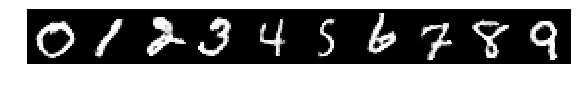

In [16]:
tf.logging.info('Start Training.')
global_step = tf.train.get_or_create_global_step()

sample_condition = tf.eye(num_classes)
sample_condition = tf.reshape(sample_condition, [-1, 1, 1, num_classes])
  
for epoch in range(max_epochs):
  
  for images, labels in train_dataset:
    start_time = time.time()
    
    # generating noise from a uniform distribution
    noise = tf.random_normal([batch_size, 1, 1, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)

      real_logits = discriminator(images, labels, training=True)
      fake_logits = discriminator(generated_images, labels, training=True)

      gen_loss = generator_loss(fake_logits)
      disc_loss = discriminator_loss(real_logits, fake_logits)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables),
                                        global_step=global_step)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
    
    epochs = global_step.numpy() * batch_size / float(N)
    duration = time.time() - start_time

    if global_step.numpy() % print_steps == 0:
      display.clear_output(wait=True)
      examples_per_sec = batch_size / float(duration)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      sample_images = generator(random_vector_for_generation, sample_condition, training=False)
      utils.print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)

  if epoch % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = generator(random_vector_for_generation, sample_condition, training=False)
    utils.print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                      is_save=True, epoch=epoch+1,
                                      checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

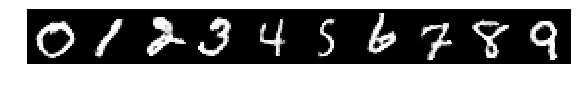

In [17]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = generator(random_vector_for_generation, sample_condition, training=False)
utils.print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                  is_save=True, epoch=epoch+1,
                                  checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [18]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

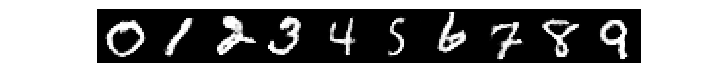

In [19]:
utils.display_image(max_epochs, checkpoint_dir)

## Generate a GIF of all the saved images.

In [20]:
filename = model_name + '.gif'
utils.generate_gif(filename, checkpoint_dir)

cp cgan.gif cgan.gif.png


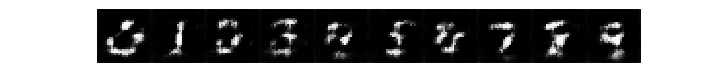

In [21]:
display.Image(filename=filename + '.png')